In [1]:
import numpy as np
import pandas as pd
import torch
import nltk
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline


c:\Users\drebi\miniconda3\envs\FinBERT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
news_df = pd.read_csv('data/news.csv')
stock_df = pd.read_csv('data/price.csv')


In [ ]:
stock_df.head()

In [ ]:
nltk.download("vader_lexicon")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
finbert_tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, max_length=512, truncation=True)


def predict_sentiment(text):
    inputs = finbert_tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    with torch.no_grad():
        outputs = finbert(**inputs)
    scores = outputs.logits.softmax(dim=1).numpy()[0]
    return scores

In [51]:
# Convert the list of scores into a DataFrame with separate columns
sentiment_df = pd.DataFrame(
    news_df["body"].apply(predict_sentiment).tolist(),
    columns=["neutral", "positive", "negative"],
)

# Append the new columns to news_df
news_df = pd.concat([news_df.reset_index(drop=True), sentiment_df], axis=1)

In [24]:
def VADER_sentiment_score(heading):
    """
    Returns all VADER sentiment scores
    - neg: Negative sentiment (0 to 1)
    - neu: Neutral sentiment (0 to 1)
    - pos: Positive sentiment (0 to 1)
    compound: Normalized aggregate score (-1 to 1)
    """

    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(heading)

In [ ]:
VADER_negative = []
VADER_neutral = []
VADER_positive = []
VADER_compound = []


for i in range(len(news_df)):

    headline = news_df.iloc[i]["title"]

    # Analyze headline with VADER
    vader_scores = VADER_sentiment_score(headline)
    VADER_negative.append(vader_scores["neg"])
    VADER_neutral.append(vader_scores["neu"])
    VADER_positive.append(vader_scores["pos"])
    VADER_compound.append(vader_scores["compound"])

    # Optional: Print progress every 100 items
    if i % 100 == 0:
        print(f"Processed {i} items")

    # Get all sentiment scores

# Add all scores to the dataframe
news_df["VADER_negative"] = VADER_negative
news_df["VADER_neutral"] = VADER_neutral
news_df["VADER_positive"] = VADER_positive
news_df["VADER_compound"] = VADER_compound

In [ ]:
news_df.head()

In [18]:
news_df.to_csv('data/news_w_sentiment.csv', index=False)

In [2]:
# loading stock price and news data
stock_data = pd.read_csv("data/price.csv")
news_data = pd.read_csv("data/news_w_sentiment.csv")

news_data['FinBERT score'] = news_data['positive'] - news_data['negative']

stock_column = ['close']
news_column = ['FinBERT score']


In [3]:
def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (
            np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
        )
    else:
        if benchmark is None:
            raise ValueError(
                "Benchmark must be provided for out-of-sample R-squared calculation."
            )
        return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - benchmark) ** 2))

In [ ]:
# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 10
learning_rate = 0.01

# loading stock price data
stock_data = pd.read_csv("data/price.csv")
column = ['close']


len_stock_data = stock_data.shape[0]


# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


# MLP Model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units=50, activation="tanh", return_sequences=True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units=20, activation="tanh", return_sequences=False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units=1, activation="linear"),
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    )

    # Fit the model and store the history
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_split=0.2,
        verbose=1
    )
    return model, history


# inverting normaliztion
y_test = scaler.inverse_transform(y_test)


# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, 1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark = 0)
    return mae, mape, (1 - mape), r2


def run_model(n):

    total_mae = total_mape = total_acc =total_r2 = 0
    histories = []

    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2 = evaluate(predictions)
        total_mae += mae
        total_mape += mape
        total_acc += acc
        total_r2 += r2
        histories.append(history)

    return (total_mae / n), (total_mape / n), (total_acc / n), histories, predictions.tolist(), (total_r2/n)

mae, mape, acc, preds, histories, r2 = run_model(1)


print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R2 Score = {r2}")

In [ ]:
stock_data = pd.read_csv("data/price.csv")
column = ['close']

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 10
learning_rate = 0.02
validation_split = 0.2  # 20% of training data for validation

len_stock_data = stock_data.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Train the model with validation split
    history = model.fit(
        X_train, y_train,
        epochs = epochs,
        validation_split = validation_split,
        verbose = 1
    )
    
    return model, history

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    return mae, mape, (1 - mape), r2


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = total_r2 = 0
    histories = []
    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), predictions.tolist(), (total_r2 / n), histories

mae, mape, acc, preds, r2, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")


plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
stock_data[stock_data['ticker'] == 'SPX']


,Date,ticker,close
602582,2017-01-03,SPX,2257.830078
602583,2017-01-04,SPX,2270.750000
602584,2017-01-05,SPX,2269.000000
602585,2017-01-06,SPX,2276.979980
602586,2017-01-09,SPX,2268.899902
...,...,...,...
603835,2021-12-23,SPX,4725.790039
603836,2021-12-27,SPX,4791.189941
603837,2021-12-28,SPX,4786.350098
603838,2021-12-29,SPX,4793.060059


In [17]:

sp = stock_data[stock_data['ticker'] == 'SPX']

In [20]:
sp.shape[0]

1258

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0369 - val_loss: 0.0415
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0242
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0206
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 0.0086
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0084
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2455e-04 - val_loss: 0.0036
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mean Absolute Error = 40.63420369238827
Mean Absolute Percentage Error = 0.009194088617500117%
Accuracy = 0.99080591

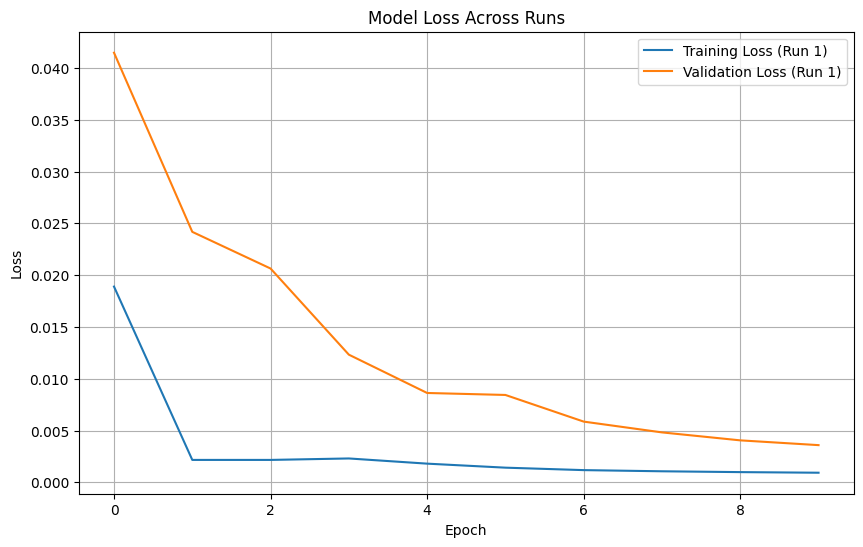

In [21]:

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 10
learning_rate = 0.02



# loading stock price and news data
stock_data = pd.read_csv("data/price.csv")
news_data = pd.read_csv("data/news_w_sentiment.csv")

news_data['FinBERT score'] = news_data['positive'] - news_data['negative']

sp = stock_data[stock_data['ticker'] == 'SPX']
stock_column = ['close']
news_column = ['FinBERT score']

len_stock_data = sp.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = sp.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = sp.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)


# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)


# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    # Check if we have sentiment data
    if len_train_sentiment > 0:
        if i + sequence_length < len_train_sentiment:
            X_train[i].append(train_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_train[i].append(train_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_train[i].append([0.0])
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    # Check if we have sentiment data
    if len_test_sentiment > 0:
        if i + sequence_length < len_test_sentiment:
            X_test[i].append(test_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_test[i].append(test_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_test[i].append([0.0])
X_test = np.array(X_test).astype(float)

def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

#%%
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 70, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 10, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Split training data into training and validation sets (80-20 split)
    val_split = 0.2
    val_size = int(len(X_train) * val_split)
    
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train_new = X_train[:-val_size]
    y_train_new = y_train[:-val_size]

    # Train the model with validation data
    history = model.fit(
        X_train_new, y_train_new,
        validation_data=(X_val, y_val),
        epochs = epochs,
        verbose=1
    )
    
    return model, history

#%%

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions



# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    return mae, mape, (1 - mape), r2


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc= total_r2 = 0
    histories = []
    global predictions
    for i in range(n):
        model, history = model_create()  # Modified to receive history
        predictions = predict(model)
        mae, mape, acc, r2 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), (total_r2 / n), histories

#%%
# Run the model and get the histories
mae, mape, acc, r2, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")

# Plot the final training and validation loss
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# %%


In [30]:
news_data.iloc[len_train:]

,publication_datetime,title,body,tickers,neutral,positive,negative,VADER_negative,VADER_neutral,VADER_positive,VADER_compound,FinBERT score
1069,2017-03-29,Eczema Drug Gets 'Responsible' Price,"With the negotiations, the companies said they...",REGN,0.999292,0.000165,0.000543,0.000,1.000,0.000,0.0000,-0.000377
1070,2017-03-29,Facebook Moves Onto Snap's Turf,Facebook said Tuesday it is launching new feat...,META,0.000067,0.000019,0.999914,0.000,1.000,0.000,0.0000,-0.999895
1071,2017-03-29,Google's Too-Darn-Bad Scandal,"Understandably, though, advertisers, especiall...",GOOGL,0.991253,0.004513,0.004234,0.592,0.408,0.000,-0.4404,0.000280
1072,2017-03-29,BlackRock Shake-Up Favors Computers Over Humans,But its stock-picking unit -- which depends on...,BLK,0.971091,0.008548,0.020362,0.000,0.714,0.286,0.2500,-0.011814
1073,2017-03-29,Facebook's Additions Flatter Snapchat -- And P...,Facebook is also making the camera accessible ...,META,0.972036,0.027930,0.000034,0.190,0.690,0.121,-0.2023,0.027895
...,...,...,...,...,...,...,...,...,...,...,...,...
20545,2020-12-30,Terms in Google Ad Deal Revealed,"Ten Republican attorneys general, led by Texas...",GOOGL,0.233788,0.031028,0.735184,0.000,1.000,0.000,0.0000,-0.704156
20546,2020-12-30,'Son of Sam' Law Invoked in Phony Heiress Case,"Last year, the New York state attorney general...",NFLX,0.999567,0.000021,0.000413,0.000,1.000,0.000,0.0000,-0.000392
20547,2020-12-30,Boeing MAX Returns to U.S. Sky,Daily round-trip flights between Miami and New...,BA,0.999890,0.000064,0.000045,0.000,1.000,0.000,0.0000,0.000019
20548,2020-12-30,"To Curb Ma's Empire, China Weighs Taking a Big...","The regulators, led by the central bank, also ...",PYPL,0.996614,0.002923,0.000463,0.000,1.000,0.000,0.0000,0.002461


In [35]:
news_data[news_data['publication_datetime'] > '2020-12-15']


,publication_datetime,title,body,tickers,neutral,positive,negative,VADER_negative,VADER_neutral,VADER_positive,VADER_compound,FinBERT score


In [37]:
len(news_data)


20550

In [41]:
news_data.iloc[:-189]

,publication_datetime,title,body,tickers,neutral,positive,negative,VADER_negative,VADER_neutral,VADER_positive,VADER_compound,FinBERT score
0,2017-01-03,World News: Police Question Netanyahu Over Gifts,"""We pay attention to publications in the media...",EL,0.999937,0.000002,0.000060,0.000,1.000,0.000,0.0000,-0.000058
1,2017-01-03,Business News: Nestle Turns to New CEO for Hea...,"Nestle, the world's largest packaged-food comp...",GIS,0.444897,0.551795,0.003308,0.000,1.000,0.000,0.0000,0.548488
2,2017-01-03,Business News: Vermont Drug Law Faces Limits -...,"The Vermont law, enacted in June, instructed s...",ABBV,0.999891,0.000026,0.000083,0.000,1.000,0.000,0.0000,-0.000057
3,2017-01-03,Life & Arts -- Travel: How Hotel Companies Lau...,Travelers are about to see a flurry of new hot...,HLT,0.999991,0.000006,0.000003,0.000,1.000,0.000,0.0000,0.000003
4,2017-01-03,Businesses Ready to Ramp Up Investment --- Aft...,The Federal Reserve last month signaled intere...,HD,0.984549,0.013953,0.001498,0.000,0.894,0.106,0.3612,0.012455
...,...,...,...,...,...,...,...,...,...,...,...,...
20356,2020-12-14,Corrections,---\n\nSeth Meyers received an honorary doctor...,NFLX,0.999932,0.000006,0.000062,0.000,1.000,0.000,0.0000,-0.000056
20357,2020-12-14,One Hurdle on Shot: Convincing Skeptics,"""They sure pushed it hard and fast,"" said Ms. ...",PFE,0.998868,0.000081,0.001051,0.173,0.494,0.333,0.3182,-0.000969
20358,2020-12-15,SEC's New Stock-Exchange Rules Have Pluses,Exchanges have always fought hard for market s...,CBOE,0.991593,0.002312,0.006095,0.000,1.000,0.000,0.0000,-0.003783
20359,2020-12-15,New Apple App Can Replace Your Gym,Fitness+ will appear as a new tab in Apple's e...,AAPL,0.999644,0.000347,0.000009,0.000,1.000,0.000,0.0000,0.000337


In [40]:
len

20550